# 1- Data Acquisition

We are going to use a dataset that is already collected.

In [1]:
pip install wordcloud tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 17.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.5 MB/s eta 0

In [2]:
import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


2024-04-24 10:14:03.271391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 10:14:05.161397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def jsonl_to_dataframe(file_path):
    """Fonction pour lire un fichier JSONL et retourner un DataFrame pandas"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

def merge_jsonl_to_dataframe(file_pattern):
    """Fonction pour fusionner plusieurs fichiers JSONL en un seul DataFrame pandas"""
    # Récupérer la liste des fichiers correspondant au modèle fourni
    files = glob(file_pattern)
    
    
    # Lire chaque fichier JSONL et stocker les DataFrames individuels dans une liste
    dfs = [jsonl_to_dataframe(file) for file in files]
    # Concaténer les DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)
    
    return merged_df

# Modèle de chemin vers les fichiers JSONL à fusionner
file_pattern = "data/*.jsonl"

# Appel de la fonction pour fusionner les fichiers JSONL en un DataFrame
df = merge_jsonl_to_dataframe(file_pattern)

# Afficher le DataFrame fusionné
len(df)

48644

#  Setup the dataFrame for the predictive models

In [20]:
#human_df = pd.DataFrame({'questions': df['question'], 'answers': df['human_answers'], 'is_human': 1 })
#gpt_df = pd.DataFrame({'questions': df['question'], 'answers': df['chatgpt_answers'], 'is_human': 0})
#answers_df = pd.concat([human_df, gpt_df], axis=0, ignore_index=True)

csv = pd.read_csv("data/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
csv = csvFull.drop(columns="src")
answers_df = csv

answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)

answers_df

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1
...,...,...
56814,We consider the recovery of a source term f (x...,1
56815,"Self-supervised learning (SlfSL), aiming at le...",1
56816,Recurrent neural networks (RNNs) have achieved...,1
56817,Deep reinforcement learning (DRL) is a booming...,1


In [21]:
answers_df.head()

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


# 2. Exploring the data

Whenever we start working with a new dataset, and before we move on to making design decisions and creating a model, we have to get to know our data. Let’s answer some questions regarding our dataset:

**What does human_answers or chatgpt_answers looks like?**

In [22]:
#Human

human_answers_df = answers_df[answers_df['is_human'] == 1]
first_human_answer = human_answers_df.iloc[0]['answers']
print(first_human_answer)


Little disclaimer: this deals with US laws and procedures so I apologize if anyone outside the US isn't able to contribute, except to tell me how great it is having this in their own country. Last Sunday John Oliver's show dealt with this subject and chastised the US for being only one of two developed countries in the world without maternity leave that is paid for by the taxpayers. Here is a link to watch it if you haven't seen it yet: Here is the gist of my viewpoint: In the US, when a person is terminated from a job, heshe is entitled to unemployment benefits for up to 99 weeks or until they are employed again. Workers and companies pay into this and, while many people end up taking more than they give, it is the system we have and it seems to work for the majority of people here. When a person leaves a job VOLUNTARILY, however, they are not entitled to unemployment benefits. If you quit a job to go to another job this is fine. If you are quitting to go'find' yourself in Australia f

In [23]:
#Chatgpt

chatgpt_answers_df = answers_df[answers_df['is_human'] == 0]
first_chatgpt_answer = chatgpt_answers_df.iloc[0]['answers']
print(first_chatgpt_answer)

Little disclaimer: this deals with US laws and procedures so I apologize if anyone outside the US isn't able to contribute, except to tell me how great it is having this blog is now a book


**How long are the responses? from humans? from chatgpt?**

Mean responses length:  1172.9371281444626
Min overview length:  24
Max overview length:  63723


/tmp/ipykernel_90800/4104485100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_answers_df['responses_length'] = human_answers_df.answers.apply(len)


<Axes: ylabel='Frequency'>

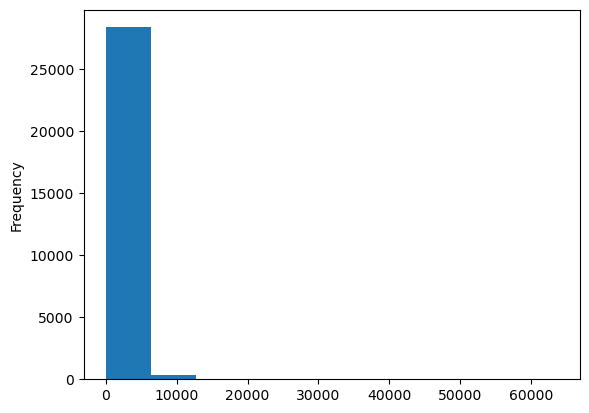

In [24]:
#Human 

human_answers_df['responses_length'] = human_answers_df.answers.apply(len)
print("Mean responses length: ", human_answers_df['responses_length'].mean())
print("Min overview length: ", human_answers_df['responses_length'].min())
print("Max overview length: ", human_answers_df['responses_length'].max())
human_answers_df.responses_length.plot.hist()

Mean responses length:  1010.5089395234733
Min overview length:  0
Max overview length:  3508


/tmp/ipykernel_103124/2606865523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)


<Axes: ylabel='Frequency'>

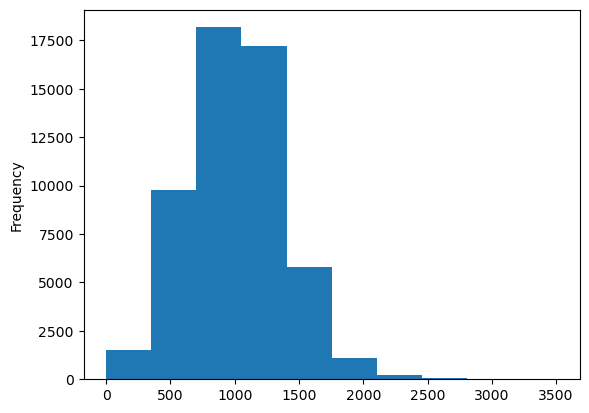

In [ ]:
#Chatgpt

chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)
print("Mean responses length: ", chatgpt_answers_df['responses_length'].mean())
print("Min overview length: ", chatgpt_answers_df['responses_length'].min())
print("Max overview length: ", chatgpt_answers_df['responses_length'].max())
chatgpt_answers_df.responses_length.plot.hist()

**A word cloud to see what are the most common words in the responses**

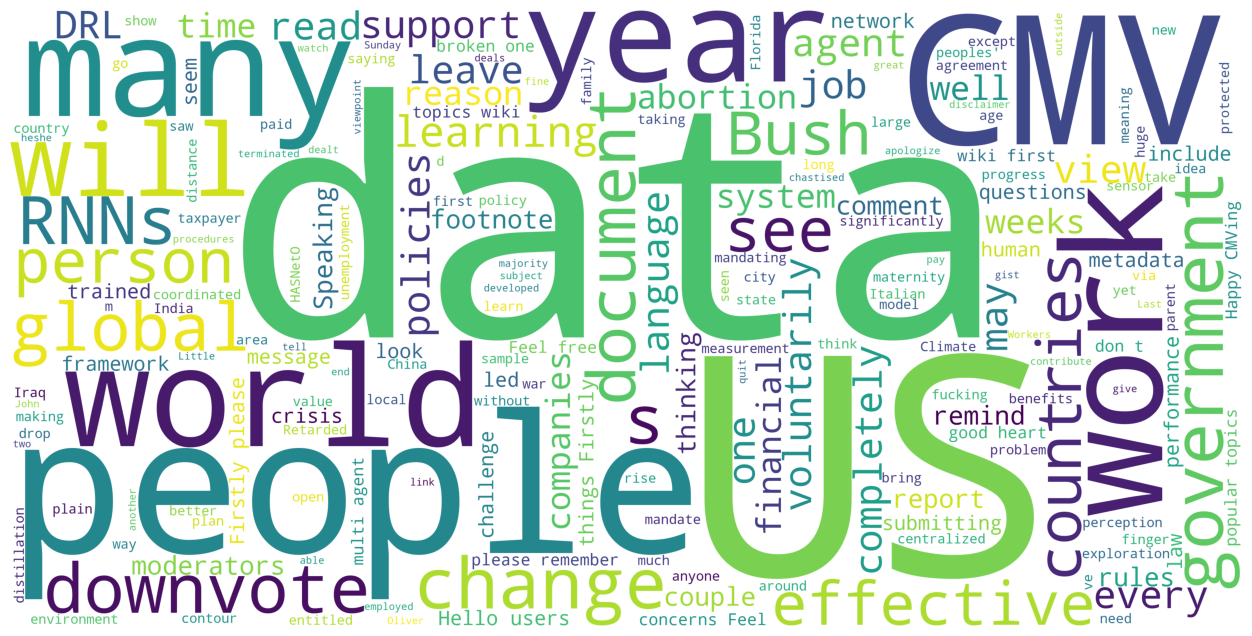

In [25]:
#Human

stopwords = set(STOPWORDS)
humans_words_text = human_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(humans_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


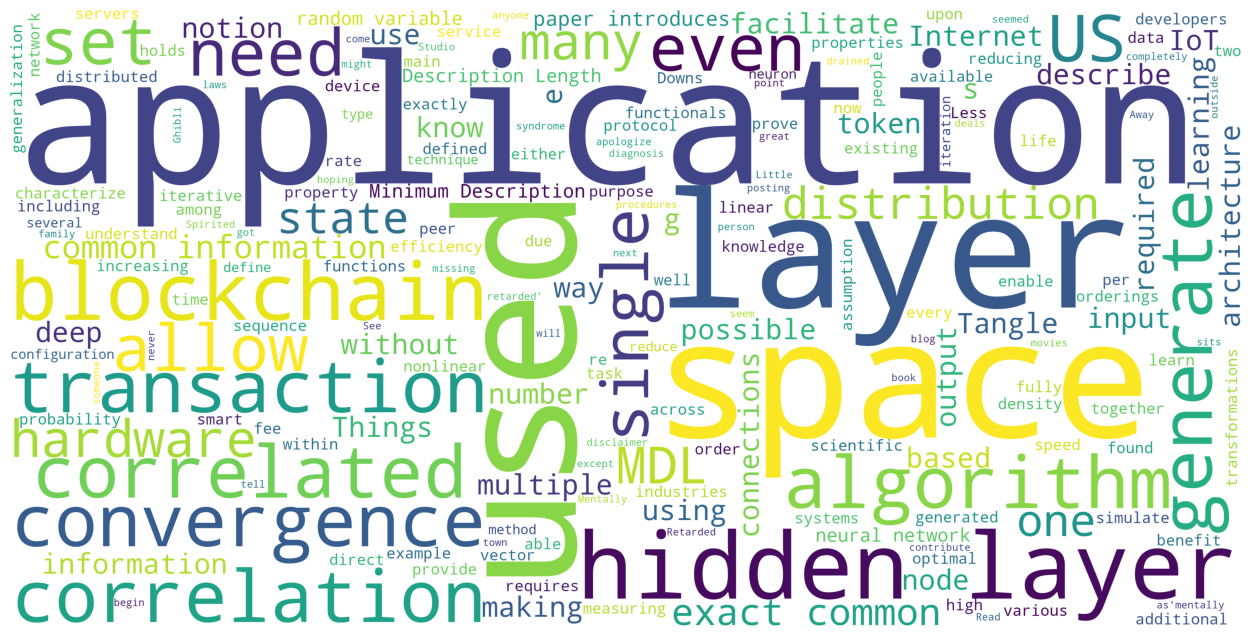

In [26]:
#Chatgpt

stopwords = set(STOPWORDS)
chatgpt_words_text = chatgpt_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(chatgpt_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

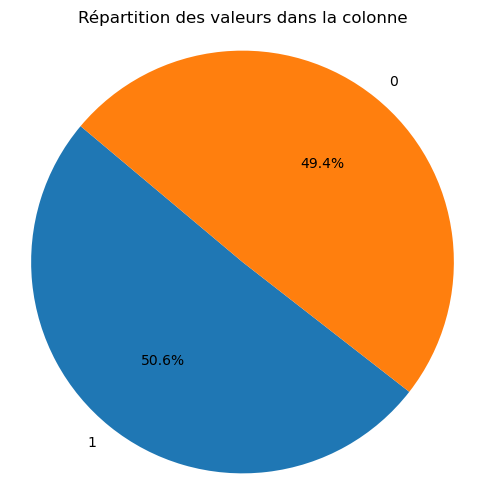

In [27]:
counts = answers_df["is_human"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Assurer que le cercle est tracé comme un cercle
plt.title('Répartition des valeurs dans la colonne')
plt.show()

In [ ]:
X = answers_df['answers']
y = answers_df['is_human']

#Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = 100  # Choisissez la longueur maximale souhaitée
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)


**Construction du Modèle de Réseau de Neurones**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 64, input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Architecture du modèle :")
model.summary()

Architecture du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
# Entraînement du modèle
print("\nTraining start...")
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val))


Training start...
Epoch 1/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9579 - loss: 0.1116 - val_accuracy: 0.9929 - val_loss: 0.0225
Epoch 2/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.9942 - val_loss: 0.0220
Epoch 3/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9944 - val_loss: 0.0310
Epoch 4/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9946 - val_loss: 0.0261
Epoch 5/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9997 - loss: 8.1696e-04 - val_accuracy: 0.9959 - val_loss: 0.0278
Epoch 6/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.9999 - loss: 4.2933e-04 - val_accuracy: 0.9951 - val_loss: 0.0299
Epoch 7/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9998 - loss: 3.7451e-04 - val_accuracy: 0.9948 - val_loss: 0.0394
Epoch 8/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/

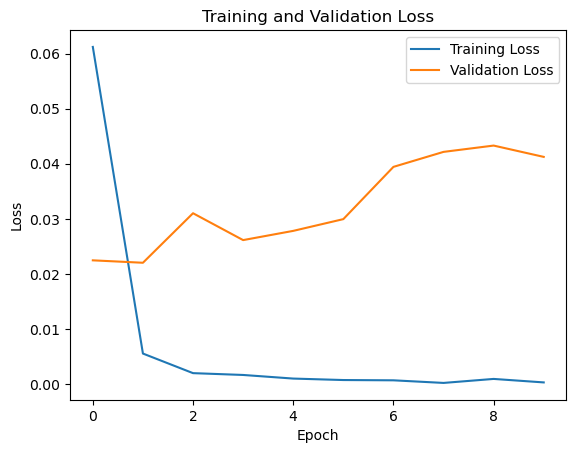

In [ ]:
# Affichage de l'historique de la perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

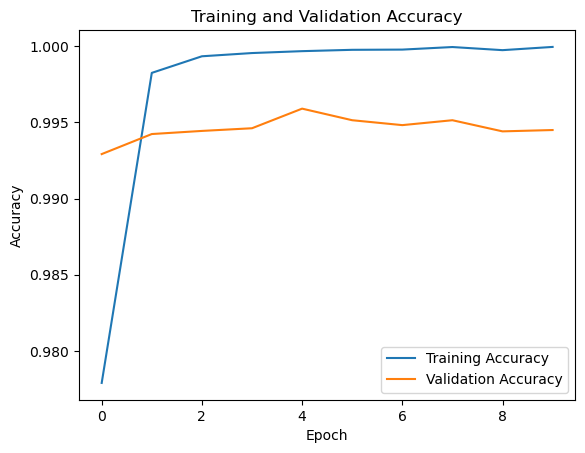

In [ ]:
# Affichage de l'historique de la précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Supposons que X_test contient vos données de test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1069/1069 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9949 - loss: 0.0386
Test Loss: 0.041242796927690506
Test Accuracy: 0.994499683380127


In [ ]:
predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype(int)

1069/1069 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Text(0.5, 1.0, 'Matrice de confusion')

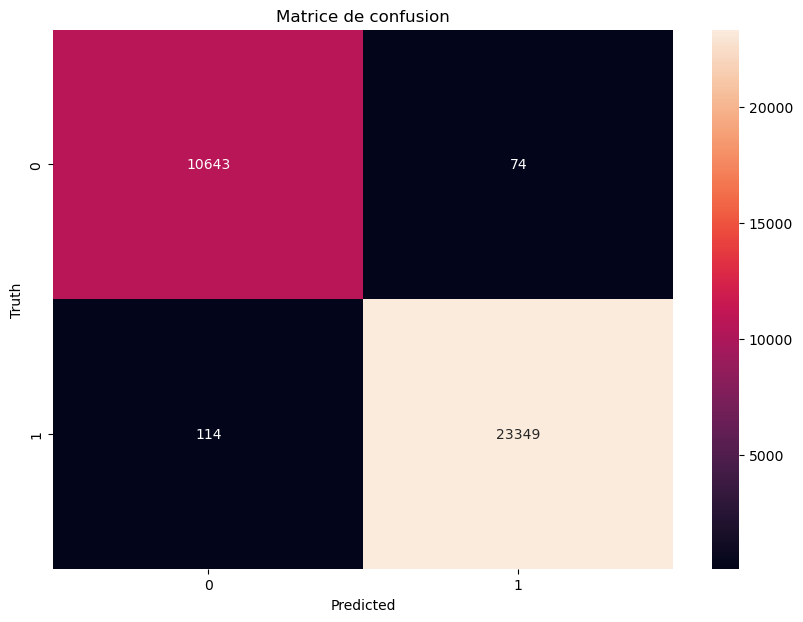

In [ ]:
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Matrice de confusion')

In [ ]:
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10717
           1       1.00      1.00      1.00     23463

    accuracy                           0.99     34180
   macro avg       0.99      0.99      0.99     34180
weighted avg       0.99      0.99      0.99     34180



In [ ]:
import colorama
from colorama import Fore, Style
from tensorflow.keras.preprocessing.sequence import pad_sequences

colorama.init(autoreset=True)

test_answers = [
    ('Who is the strongest between Itachi and Jiraiya?', 
    'Itachi is stronger by far and I can prove it.', 
    """It's hard to determine conclusively who is stronger between Itachi and Jiraiya.
     Both have unique strengths and weaknesses. Itachi excels in Sharingan and genjutsu mastery,
      while Jiraiya is a proficient user of ninjutsu and senjutsu. Their relative power depends on various factors, 
      including their respective skills, combat strategies, and physical/mental condition during battle."""
    )
]

def human_or_gpt(n):
    label = "HUMAN" if n[0][0] > 0.5 else 'GPT'
    return Fore.BLUE + label + Style.RESET_ALL

def testsuite(model, tests, tokenizer, max_len):
    for test in tests:
        (qst, human, gpt) = test
        print(f"Question: {qst}")
        
        # Tokenization and padding
        human_seq = tokenizer.texts_to_sequences([human])
        human_pad = pad_sequences(human_seq, maxlen=max_len)
        gpt_seq = tokenizer.texts_to_sequences([gpt])
        gpt_pad = pad_sequences(gpt_seq, maxlen=max_len)
        
        # Prediction
        human_pred = model.predict(human_pad)
        gpt_pred = model.predict(gpt_pad)
        
        print(f"Human Answer: [{human[:25]}] the model thinks it was written by a {human_or_gpt(human_pred)}")
        print(f"GPT Answer: [{gpt[:25]}] the model thinks it was written by a {human_or_gpt(gpt_pred)}")

# Exemple d'utilisation de la fonction avec le tokenizer et max_len appropriés
testsuite(model, test_answers, tokenizer, max_len) 



Question: Who is the strongest between Itachi and Jiraiya?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Human Answer: [Itachi is stronger by far] the model thinks it was written by a HUMAN
GPT Answer: [It's hard to determine co] the model thinks it was written by a GPT
